# A Neural Algorithm of Artistic Style
### Leon A. Gatys, Alexander S. Ecker, Matthias Bethge

#####  A picture describes things in a better way. The main objective of this paper is a neural network based algorithm for generating images with a particular content and style as show below. First Image is the famous painting of Mona Lisa. Second Image is Pablo Picaso's cubist style. Third Image is the image generated by the convolutional neural network (CNN). 

![](https://miro.medium.com/max/1400/1*kOQOZxBDNw4lI757soTEyQ.png)

### The Libraries used for this notebook

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from keras import backend as K
import os
from keras.applications import vgg19
from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
from keras.models import Model
from keras.preprocessing.image import load_img, save_img, img_to_array
from scipy.optimize import fmin_l_bfgs_b
import PIL
%matplotlib inline

In [2]:
tf.compat.v1.disable_eager_execution()

### Style Images

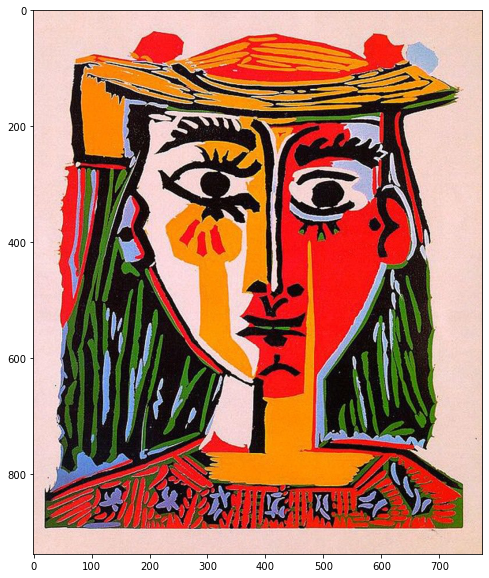

In [3]:
folder_path_style='/kaggle/input/best-artworks-of-all-time/images/images/'
files_path=folder_path_style+'Pablo_Picasso/Pablo_Picasso_331.jpg'
style_image=load_img(files_path)
plt.figure(figsize=(10,10))
plt.imshow(style_image)

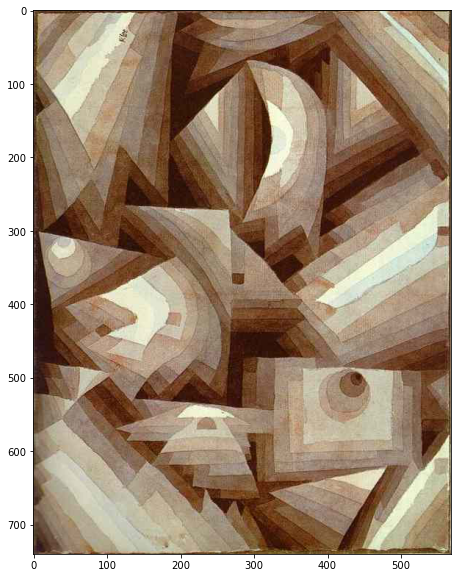

In [4]:
files_path=folder_path_style+'Paul_Klee/Paul_Klee_24.jpg'
style_image=load_img(files_path)
plt.figure(figsize=(10,10))
plt.imshow(style_image)

### Content Images

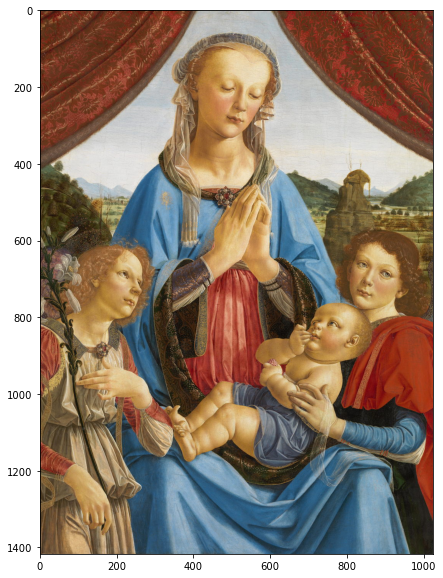

In [5]:
folder_path_content='/kaggle/input/best-artworks-of-all-time/images/images/Leonardo_da_Vinci/'
files_path=folder_path_content + 'Leonardo_da_Vinci_1.jpg'
style_image=load_img(files_path)
plt.figure(figsize=(10,10))
plt.imshow(style_image)

In [6]:
current_content_image_path = folder_path_content + 'Leonardo_da_Vinci_1.jpg'
current_style_image_path = folder_path_style + '/Pablo_Picasso/Pablo_Picasso_331.jpg'

In [7]:
IMG_HEIGHT=512
IMG_WIDTH=512

In [8]:
def preprocess_image(img_path):
    img=load_img(img_path,target_size=(IMG_HEIGHT,IMG_WIDTH))
    img=img_to_array(img)
    img=np.expand_dims(img, axis=0)
    processed_img=vgg19.preprocess_input(img)
    return processed_img

In [9]:
content_image_tensor=K.variable(preprocess_image(current_content_image_path))
style_image_tensor=K.variable(preprocess_image(current_style_image_path))

In [10]:
content_image_tensor.shape,style_image_tensor.shape

(TensorShape([1, 512, 512, 3]), TensorShape([1, 512, 512, 3]))

In [11]:
#K.image_data_format()

In [12]:
gen_image_tensor=K.placeholder((1,IMG_HEIGHT, IMG_WIDTH,3))#K.placeholder(np.random.randint(low=0,high=255,size=(1,IMG_HEIGHT, IMG_WIDTH,3)))

In [13]:
print(gen_image_tensor.shape)

(1, 512, 512, 3)


In [14]:
input_tensor=K.concatenate([content_image_tensor, style_image_tensor, gen_image_tensor], axis=0)

In [15]:
model=VGG19(input_tensor=input_tensor, include_top=False, weights='imagenet')
model.trainable = False

80142336/80134624 [==============================] - 1s 0us/step


In [16]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(3, 512, 512, 3)]        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 512, 512, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 512, 512, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 256, 256, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 256, 256, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 256, 256, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 128, 128, 128)        0     

In [17]:
def J_content(content, generated):
    return K.sum(K.square(generated-content))

In [18]:
def gram_matrix(tensor):
    N_C=int(tensor.shape[-1])
    tensor=tf.reshape(tensor,[-1,N_C])
    gram_m=tf.matmul(tensor, tensor, transpose_a=True)
    return gram_m

In [19]:
def J_style(style, generated):
    s_gram=gram_matrix(style)
    g_gram=gram_matrix(generated)
    return K.sum(K.square(s_gram-g_gram))

In [20]:
ALPHA=0.5
BETA=1.0

In [21]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

In [22]:
J_cost=K.variable(0.0)
content_layer_output=outputs_dict["block5_conv2"]
content_image_feature=content_layer_output[0,:,:,:]
generated_image_feature=content_layer_output[2,:,:,:]
J_cost = J_cost + ALPHA*J_content(content_image_feature, generated_image_feature)

In [23]:
style_feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer in style_feature_layers:
    layer_feature=outputs_dict[layer]
    style_image_feature=layer_feature[1,:,:,:]
    generated_image_feature=layer_feature[2,:,:,:]
    J_cost = J_cost + (BETA/len(style_feature_layers))*J_style(style_image_feature, generated_image_feature)

In [24]:
def deprocess_image(img):
    img=img.reshape((IMG_HEIGHT,IMG_WIDTH,3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1] #BGR to RGB
    img = np.clip(img, a_min=0, a_max=255).astype(np.uint8)
    return img

In [25]:
def clip(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=255)

In [26]:
gen_image=preprocess_image(current_content_image_path)

In [27]:
opt=tf.compat.v1.train.AdamOptimizer(
    learning_rate=1e-2, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False,
    name='Adam'
)

In [28]:
grads=K.gradients(J_cost, gen_image_tensor)

In [29]:
outputs = [J_cost]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([gen_image_tensor], outputs)
f_outputs

def train(gen_image, iterations=1):
    best_image, min_cost = None, np.inf
    for i in range(iterations):
        loss, grads = f_outputs([gen_image])
        print("Loss at iteration ",i+1," = ",loss)
        opt.apply_gradients([(grads,gen_image)])
        gen_image.assign(clip(gen_image))
        if loss < min_cost:
            best_image=gen_image
            min_cost=loss
    return best_image
        

best_image=train(gen_image,iterations=5)

best_image_np=K.get_value(best_image)
best_image_pro=deprocess_image(best_image_np)
plt.figure(figsize=(10,10))
plt.imshow(best_image_pro)
plt.show()

In [30]:
def get_loss_and_grads(image):
    image=image.reshape((1,IMG_HEIGHT,IMG_WIDTH,3))
    output=f_outputs([image])
    loss_v=output[0]
    if len(output[1:]) == 1:
        grad_values = output[1].flatten().astype('float64')
    else:
        grad_values = np.array(output[1:]).flatten().astype('float64')
    return loss_v, grad_values

In [31]:
class evaluator(object):
    def __init__(self):
        self.loss_v=None
        self.grads_v=None
    def loss(self,image):
        assert self.loss_v is None
        loss_v, grads_v=get_loss_and_grads(image)
        self.loss_v=loss_v
        self.grads_v=grads_v
        return self.loss_v
        
    def grads(self,image):
        assert self.loss_v is not None
        grads=np.copy(self.grads_v)
        self.loss_v=None
        self.grads_v=None
        return grads

In [32]:
evalo=evaluator()

In [33]:
iterations=400
min_loss,best_image=np.inf, None
for i in range(iterations):
    gen_image, loss, info=fmin_l_bfgs_b(evalo.loss, 
                                            gen_image.flatten(), 
                                            fprime=evalo.grads, 
                                            maxfun=20,
                                            disp=True)
    print("Loss at iteration ",i+1, loss)
    if loss < min_loss:
        min_loss=loss
        print("Better cost value, Updating best_image...")
        best_image=gen_image.copy()

Loss at iteration  1 1.720036e+22
Better cost value, Updating best_image...
Loss at iteration  2 6.839191e+21
Better cost value, Updating best_image...
Loss at iteration  3 4.1936247e+21
Better cost value, Updating best_image...
Loss at iteration  4 3.0393502e+21
Better cost value, Updating best_image...
Loss at iteration  5 2.3655593e+21
Better cost value, Updating best_image...
Loss at iteration  6 1.9853334e+21
Better cost value, Updating best_image...
Loss at iteration  7 1.6757623e+21
Better cost value, Updating best_image...
Loss at iteration  8 1.46227e+21
Better cost value, Updating best_image...
Loss at iteration  9 1.3142231e+21
Better cost value, Updating best_image...
Loss at iteration  10 1.2060129e+21
Better cost value, Updating best_image...
Loss at iteration  11 1.12216495e+21
Better cost value, Updating best_image...
Loss at iteration  12 1.0460714e+21
Better cost value, Updating best_image...
Loss at iteration  13 9.852807e+20
Better cost value, Updating best_image...

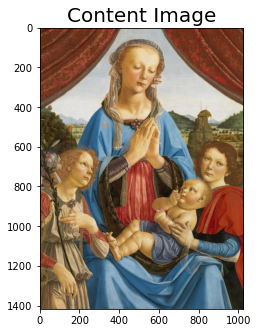

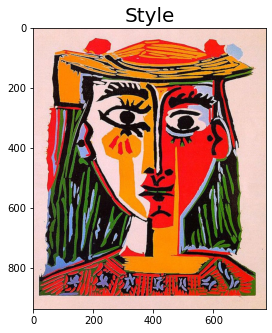

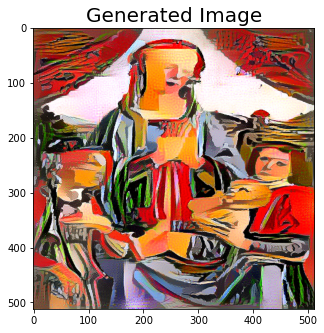

In [34]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Content Image",fontsize=20)
img_base = load_img(current_content_image_path)
plt.imshow(img_base)

plt.figure(figsize=(30,30))
plt.subplot(5,5,2)
plt.title("Style",fontsize=20)
img_base = load_img(current_style_image_path)
plt.imshow(img_base)

plt.figure(figsize=(30,30))
plt.subplot(5,5,2)
plt.title("Generated Image",fontsize=20)
plt.imshow(deprocess_image(best_image))